In [1]:
import os
import shutil
import mlflow
from glob import glob
from tqdm import tqdm
import numpy as np
import pandas as pd
import polars as pl
import re
import matplotlib
import matplotlib.pyplot as plt
plt.style.use('tableau-colorblind10')
from IPython.display import display
from scipy import stats

from dotenv import load_dotenv
load_dotenv("../.env")

import sys
sys.path.append("..")
from herec.utils import resultLoader

In [2]:
def labeler(s):

    if s == "HE_MF":
        return "HE-MF"
    if s == "HE_FM":
        return "HE-FM"
    if s == "Ciao_PART":
        return "Ciao$_{PART}$"
    if s == "MF_BPR":
        return "MF-BPR"
    if s == "ProtoMF_BPR":
        return "ProtoMF-BPR"
    if s == "HE_MF_USER_BPR":
        return "HE$_{USER}$-MF-BPR"
    if s == "HE_MF_ITEM_BPR":
        return "HE$_{ITEM}$-MF-BPR"
    if s == "HE_MF_BPR":
        return "HE-MF-BPR"
    if s == "NeuMF_BPR":
        return "NeuMF-BPR"
    if s == "HE_NeuMF_BPR":
        return "HE-NeuMF-BPR"
    if s == "metrics.nDCG_10":
        return "nDCG@10"
    if s == "metrics.HitRate_10":
        return "HitRate@10"
    if s == "metrics.Recall_10":
        return "Recall@10"
    if s == "ML100K_IMPLICIT":
        return "ML100K$_{IMPLICIT}$"
    if s == "ML1M_IMPLICIT":
        return "ML1M$_{IMPLICIT}$"

    return s

## Get Test Results

In [3]:
experiments = {experiment.experiment_id: experiment.name for experiment in mlflow.search_experiments( view_type="ACTIVE_ONLY" ) if experiment.name.endswith("-TEST")}

df_RESULT = pl.from_pandas(mlflow.search_runs( experiment_ids=experiments.keys() ))
df_RESULT = df_RESULT.select(
    pl.col("experiment_id").replace(experiments, default=None).str.split("-").list.get(0).alias("dataset_name"),
    pl.col("experiment_id").replace(experiments, default=None).str.split("-").list.get(1).alias("model_name"),
    pl.col("params.seed").cast(int),
    pl.col("^metrics(.*?)$").exclude("metrics.TRAIN_LOSS/ROUGH"),
).sort("dataset_name", "model_name")
df_RESULT = df_RESULT.with_columns( np.sqrt(pl.col("metrics.VALID_LOSS")) ) # RMSEに変換

df_RESULT

/home/sugahara/.local/lib/python3.8/site-packages/polars/series/series.py:1223: RuntimeWarning: invalid value encountered in sqrt
  series = f(lambda out: ufunc(*args, out=out, dtype=dtype_char, **kwargs))


dataset_name,model_name,params.seed,metrics.TRAIN_LOSS,metrics.VALID_LOSS,metrics.BEST_VALID_LOSS,metrics.nDCG_50,metrics.Precision_10,metrics.Coverage_50,metrics.Precision_50,metrics.Recall_100,metrics.Coverage_30,metrics.nDCG_100,metrics.nDCG_30,metrics.Precision_100,metrics.MRR_30,metrics.HitRate_10,metrics.Recall_10,metrics.Recall_50,metrics.HitRate_50,metrics.MRR_10,metrics.HitRate_100,metrics.Coverage_10,metrics.Coverage_100,metrics.MRR_50,metrics.Precision_30,metrics.nDCG_10,metrics.MRR_100,metrics.Recall_30,metrics.HitRate_30
str,str,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""Ciao""","""FM""",2,null,0.960782,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
"""Ciao""","""FM""",1,null,0.942458,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
"""Ciao""","""FM""",0,null,1.011424,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
"""Ciao""","""HE_FM""",2,null,0.94985,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
"""Ciao""","""HE_FM""",1,null,0.936802,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
"""Ciao""","""HE_FM""",0,null,0.999538,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
"""Ciao""","""HE_MF""",2,null,0.962832,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
"""Ciao""","""HE_MF""",1,null,0.93599,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
"""Ciao""","""HE_MF""",0,null,0.995068,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null


## Visualization - Explicit

ML1M
Ciao_PART


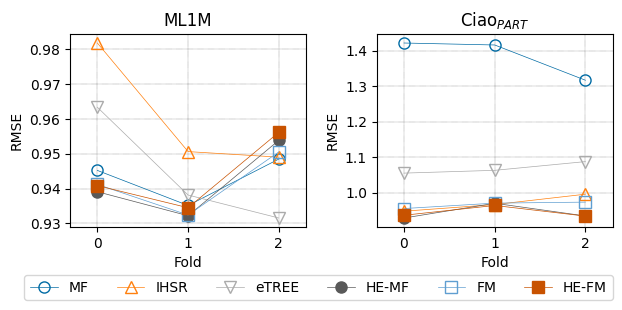

In [4]:
datasetNameList = ["ML1M", "Ciao_PART"]
modelNameList = ["MF", "IHSR", "eTREE", "HE_MF", "FM", "HE_FM"]
markerMap = {
    "MF": "o",
    "IHSR": "^",
    "eTREE": "v",
    "HE_MF": "o",
    "FM": "s",
    "HE_FM": "s",
}

# 可視化
fig, axes = plt.subplots(1, 2, figsize=(7, 2.5))
plt.subplots_adjust(wspace=0.3, hspace=0)

# データセットごとに可視化
for col_i, datasetName in enumerate(datasetNameList):

    print( datasetName )

    ## 絞る
    
    df_TARGET = df_RESULT.filter(
        (pl.col("dataset_name") == datasetName) & pl.col("model_name").is_in(modelNameList)
    ).select(
        pl.all().exclude("^metrics(.*?)$"), np.sqrt(pl.col(f"metrics.VALID_LOSS")).alias("RMSE")
    )
    
    for model_i, modelName in enumerate(modelNameList):
    
        x = df_TARGET.filter( pl.col("model_name") == modelName ).sort("params.seed").get_column("params.seed")
        y = df_TARGET.filter( pl.col("model_name") == modelName ).sort("params.seed").get_column("RMSE")
        axes[col_i].plot( x, y, linewidth=0.5, marker=markerMap[modelName], markersize=8, fillstyle=("full" if "HE_" in modelName else "none"), label=labeler(modelName) )
        axes[col_i].grid(color='black', linestyle=':', linewidth=0.3)
        axes[col_i].set_xlabel("Fold")
        axes[col_i].set_ylabel("RMSE")
    
    axes[col_i].set_title(labeler(datasetName))
    axes[col_i].set_xlim(-0.3, 2.3)
    
axes[1].legend( bbox_to_anchor=(1, -0.25), loc='upper right', borderaxespad=0, ncols=6 )
plt.savefig(f"RATING.pdf", bbox_inches='tight')
plt.show()

ML100K
ML1M
Ciao
Ciao_PART
Yelp


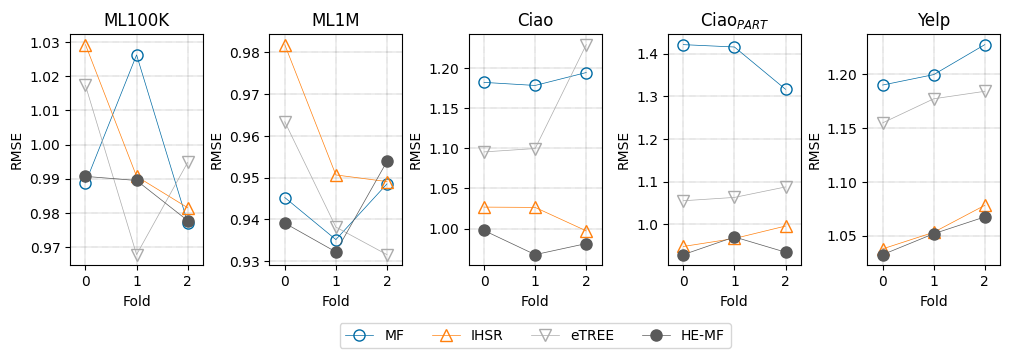

In [5]:
datasetNameList = ["ML100K", "ML1M", "Ciao", "Ciao_PART", "Yelp"]
modelNameList = ["MF", "IHSR", "eTREE", "HE_MF"]
markerMap = {
    "MF": "o",
    "IHSR": "^",
    "eTREE": "v",
    "HE_MF": "o",
    "FM": "s",
    "HE_FM": "s",
}

# 可視化
fig, axes = plt.subplots(1, 5, figsize=(12, 3))
plt.subplots_adjust(wspace=0.5, hspace=0)

# データセットごとに可視化
for col_i, datasetName in enumerate(datasetNameList):

    print( datasetName )

    ## 絞る
    
    df_TARGET = df_RESULT.filter(
        (pl.col("dataset_name") == datasetName) & pl.col("model_name").is_in(modelNameList)
    ).select(
        pl.all().exclude("^metrics(.*?)$"), np.sqrt(pl.col(f"metrics.VALID_LOSS")).alias("RMSE")
    )
    
    for model_i, modelName in enumerate(modelNameList):
    
        x = df_TARGET.filter( pl.col("model_name") == modelName ).sort("params.seed").get_column("params.seed")
        y = df_TARGET.filter( pl.col("model_name") == modelName ).sort("params.seed").get_column("RMSE")
        axes[col_i].plot( x, y, linewidth=0.5, marker=markerMap[modelName], markersize=8, fillstyle=("full" if "HE_" in modelName else "none"), label=labeler(modelName) )
        axes[col_i].grid(color='black', linestyle=':', linewidth=0.3)
        axes[col_i].set_xlabel("Fold")
        axes[col_i].set_ylabel("RMSE")
    
    axes[col_i].set_title(labeler(datasetName))
    axes[col_i].set_xlim(-0.3, 2.3)
    
axes[2].legend( bbox_to_anchor=(0.5, -0.25), loc='upper center', borderaxespad=0, ncols=6 )
plt.savefig(f"RATING.pdf", bbox_inches='tight')
plt.show()

ML100K
ML1M
Ciao
Ciao_PART
Yelp


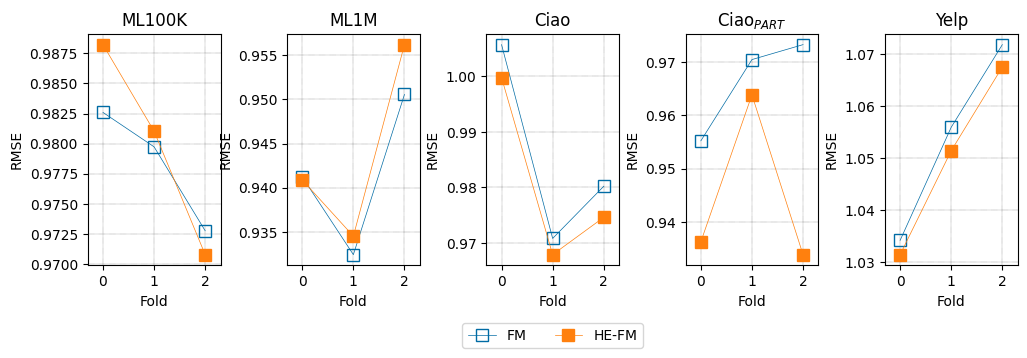

In [6]:
datasetNameList = ["ML100K", "ML1M", "Ciao", "Ciao_PART", "Yelp"]
modelNameList = ["FM", "HE_FM"]
markerMap = {
    "MF": "o",
    "IHSR": "^",
    "eTREE": "v",
    "HE_MF": "o",
    "FM": "s",
    "HE_FM": "s",
}

# 可視化
fig, axes = plt.subplots(1, 5, figsize=(12, 3))
plt.subplots_adjust(wspace=0.5, hspace=0)

# データセットごとに可視化
for col_i, datasetName in enumerate(datasetNameList):

    print( datasetName )

    ## 絞る
    
    df_TARGET = df_RESULT.filter(
        (pl.col("dataset_name") == datasetName) & pl.col("model_name").is_in(modelNameList)
    ).select(
        pl.all().exclude("^metrics(.*?)$"), np.sqrt(pl.col(f"metrics.VALID_LOSS")).alias("RMSE")
    )
    
    for model_i, modelName in enumerate(modelNameList):
    
        x = df_TARGET.filter( pl.col("model_name") == modelName ).sort("params.seed").get_column("params.seed")
        y = df_TARGET.filter( pl.col("model_name") == modelName ).sort("params.seed").get_column("RMSE")
        axes[col_i].plot( x, y, linewidth=0.5, marker=markerMap[modelName], markersize=8, fillstyle=("full" if "HE_" in modelName else "none"), label=labeler(modelName) )
        axes[col_i].grid(color='black', linestyle=':', linewidth=0.3)
        axes[col_i].set_xlabel("Fold")
        axes[col_i].set_ylabel("RMSE")
    
    axes[col_i].set_title(labeler(datasetName))
    axes[col_i].set_xlim(-0.3, 2.3)
    
axes[2].legend( bbox_to_anchor=(0.5, -0.25), loc='upper center', borderaxespad=0, ncols=6 )
plt.savefig(f"RATING.pdf", bbox_inches='tight')
plt.show()

## Visualization - Implicit

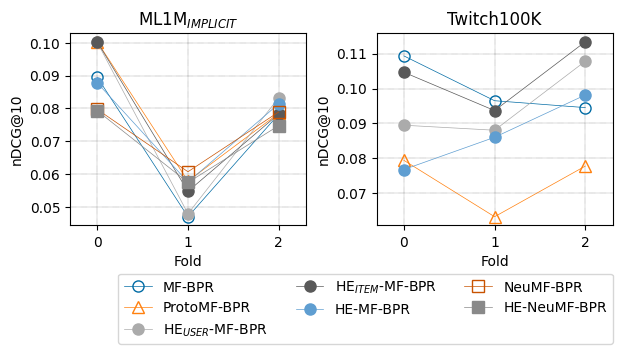

In [7]:
def work():

    datasetNameList = ["ML1M_IMPLICIT", "Twitch100K"]
    modelNameList = ["MF_BPR", "ProtoMF_BPR", "HE_MF_USER_BPR", "HE_MF_ITEM_BPR", "HE_MF_BPR", "NeuMF_BPR", "HE_NeuMF_BPR"]
    markerMap = {
        "MF_BPR": "o",
        "ProtoMF_BPR": "^",
        "HE_MF_USER_BPR": "o",
        "HE_MF_ITEM_BPR": "o",
        "HE_MF_BPR": "o",
        "NeuMF_BPR": "s",
        "HE_NeuMF_BPR": "s",
    }
    metricMap = { f"{metricName}_{k}": f"{metricName}@{k}" for metricName in ["nDCG", "HitRate", "Recall"] for k in [10] }
    
    ## 絞る
    
    df_TARGET = df_RESULT.filter(
        (pl.col("dataset_name").is_in(datasetNameList)) & pl.col("model_name").is_in(modelNameList)
    ).select(
        [pl.all().exclude("^metrics(.*?)$")] + [pl.col(f"metrics.{old_name}").alias(new_name) for old_name, new_name in metricMap.items()]
    )
    
    ## 可視化
    
    fig, axes = plt.subplots(1, 2, figsize=(7, 2.5))
    plt.subplots_adjust(wspace=0.3, hspace=0)
    
    for col_i, datasetName in enumerate(datasetNameList):
    
        for model_i, modelName in enumerate(modelNameList):
        
            x = df_TARGET.filter( (pl.col("dataset_name") == datasetName) & (pl.col("model_name") == modelName) ).sort("params.seed").get_column("params.seed")
            y = df_TARGET.filter( (pl.col("dataset_name") == datasetName) & (pl.col("model_name") == modelName) ).sort("params.seed").get_column("nDCG@10")
            axes[col_i].plot( x, y, linewidth=0.5, marker=markerMap[modelName], markersize=8, fillstyle=("full" if "HE_" in modelName else "none"), label=labeler(modelName) )
            axes[col_i].grid(color='black', linestyle=':', linewidth=0.3)
            axes[col_i].set_xlabel("Fold")
            axes[col_i].set_ylabel("nDCG@10")
    
        axes[col_i].set_title(labeler(datasetName))
        axes[col_i].set_xlim(-0.3, 2.3)
    
    axes[1].legend( bbox_to_anchor=(1, -0.25), loc='upper right', borderaxespad=0, ncols=3 )
    plt.savefig(f"RANKING.pdf", bbox_inches='tight')
    plt.show()

work()

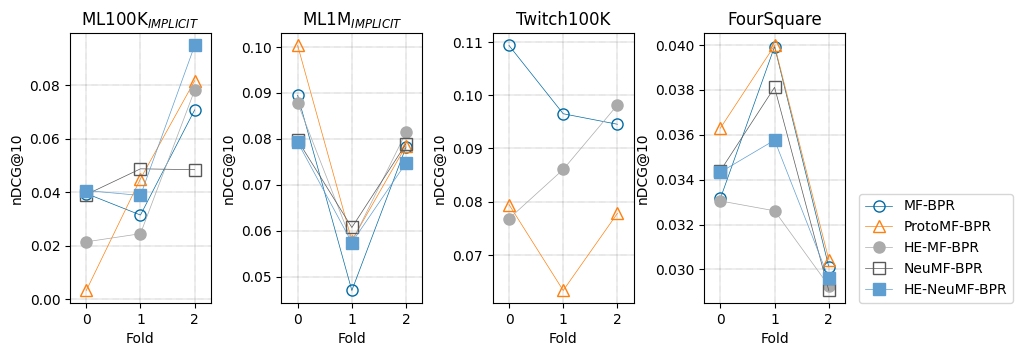

In [8]:
def work():

    datasetNameList = ["ML100K_IMPLICIT", "ML1M_IMPLICIT", "Twitch100K", "FourSquare"]
    modelNameList = [
        "MF_BPR", "ProtoMF_BPR", "HE_MF_BPR", "NeuMF_BPR", "HE_NeuMF_BPR"
    ]
    markerMap = {
        "MF_BPR": "o",
        "ProtoMF_BPR": "^",
        "HE_MF_USER_BPR": "o",
        "HE_MF_ITEM_BPR": "o",
        "HE_MF_BPR": "o",
        "NeuMF_BPR": "s",
        "HE_NeuMF_BPR": "s",
    }
    metricMap = { f"{metricName}_{k}": f"{metricName}@{k}" for metricName in ["nDCG", "HitRate", "Recall"] for k in [10] }
    
    ## 絞る
    
    df_TARGET = df_RESULT.filter(
        (pl.col("dataset_name").is_in(datasetNameList)) & pl.col("model_name").is_in(modelNameList)
    ).select(
        [pl.all().exclude("^metrics(.*?)$")] + [pl.col(f"metrics.{old_name}").alias(new_name) for old_name, new_name in metricMap.items()]
    )
    
    ## 可視化
    
    fig, axes = plt.subplots(1, 4, figsize=(10, 3.5))
    plt.subplots_adjust(wspace=0.5, hspace=0)
    
    for col_i, datasetName in enumerate(datasetNameList):
    
        for model_i, modelName in enumerate(modelNameList):
        
            x = df_TARGET.filter( (pl.col("dataset_name") == datasetName) & (pl.col("model_name") == modelName) ).sort("params.seed").get_column("params.seed")
            y = df_TARGET.filter( (pl.col("dataset_name") == datasetName) & (pl.col("model_name") == modelName) ).sort("params.seed").get_column("nDCG@10")
            axes[col_i].plot( x, y, linewidth=0.5, marker=markerMap[modelName], markersize=8, fillstyle=("full" if "HE_" in modelName else "none"), label=labeler(modelName) )
            axes[col_i].grid(color='black', linestyle=':', linewidth=0.3)
            axes[col_i].set_xlabel("Fold")
            axes[col_i].set_ylabel("nDCG@10")
    
        axes[col_i].set_title(labeler(datasetName))
        axes[col_i].set_xlim(-0.3, 2.3)
    
    axes[3].legend( bbox_to_anchor=(1.1, 0), loc='lower left', borderaxespad=0)
    plt.savefig(f"RANKING.pdf", bbox_inches='tight')
    plt.show()

work()

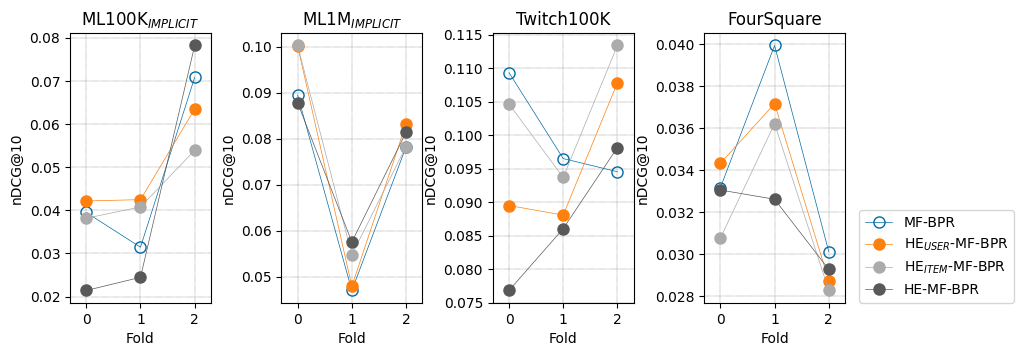

In [9]:
def work():

    datasetNameList = ["ML100K_IMPLICIT", "ML1M_IMPLICIT", "Twitch100K", "FourSquare"]
    modelNameList = [
        "MF_BPR", "HE_MF_USER_BPR", "HE_MF_ITEM_BPR", "HE_MF_BPR",
    ]
    markerMap = {
        "MF_BPR": "o",
        "ProtoMF_BPR": "^",
        "HE_MF_USER_BPR": "o",
        "HE_MF_ITEM_BPR": "o",
        "HE_MF_BPR": "o",
        "NeuMF_BPR": "s",
        "HE_NeuMF_BPR": "s",
    }
    metricMap = { f"{metricName}_{k}": f"{metricName}@{k}" for metricName in ["nDCG", "HitRate", "Recall"] for k in [10] }
    
    ## 絞る
    
    df_TARGET = df_RESULT.filter(
        (pl.col("dataset_name").is_in(datasetNameList)) & pl.col("model_name").is_in(modelNameList)
    ).select(
        [pl.all().exclude("^metrics(.*?)$")] + [pl.col(f"metrics.{old_name}").alias(new_name) for old_name, new_name in metricMap.items()]
    )
    
    ## 可視化
    
    fig, axes = plt.subplots(1, 4, figsize=(10, 3.5))
    plt.subplots_adjust(wspace=0.5, hspace=0)
    
    for col_i, datasetName in enumerate(datasetNameList):
    
        for model_i, modelName in enumerate(modelNameList):
        
            x = df_TARGET.filter( (pl.col("dataset_name") == datasetName) & (pl.col("model_name") == modelName) ).sort("params.seed").get_column("params.seed")
            y = df_TARGET.filter( (pl.col("dataset_name") == datasetName) & (pl.col("model_name") == modelName) ).sort("params.seed").get_column("nDCG@10")
            axes[col_i].plot( x, y, linewidth=0.5, marker=markerMap[modelName], markersize=8, fillstyle=("full" if "HE_" in modelName else "none"), label=labeler(modelName) )
            axes[col_i].grid(color='black', linestyle=':', linewidth=0.3)
            axes[col_i].set_xlabel("Fold")
            axes[col_i].set_ylabel("nDCG@10")
    
        axes[col_i].set_title(labeler(datasetName))
        axes[col_i].set_xlim(-0.3, 2.3)
    
    axes[3].legend( bbox_to_anchor=(1.1, 0), loc='lower left', borderaxespad=0)
    plt.savefig(f"RANKING.pdf", bbox_inches='tight')
    plt.show()

work()